# Notebook 6. Clusterization of All Time Series.

In [1]:
from typing import Union
from typing import Any
from typing import List
from typing import Set
from typing import Dict
from typing import Tuple
from typing import Optional
from typing import Callable

import os
import copy
from collections import OrderedDict
from collections import defaultdict
import pickle

import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
import matplotlib.pyplot as plt

%matplotlib inline
RANDOM_SEED: int = 42
np.random.seed(RANDOM_SEED)

import tslearn
import dtaidistance

Reading the data and loading the algorithm.

In [2]:
class DataTable: pass
complete_series: DataTable = joblib.load('prepared_data/all_data_filled_na.jbl')
dtw_km: Any = joblib.load('algorithms/dtw_km.alg')
if not os.path.exists("images/apply/"):
    os.makedirs("images/apply/")

C:\Users\nekrald\anaconda3\lib\site-packages\tslearn\clustering\kmeans.py:16: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  warnings.warn(


Method to convert DataTable into a format suitable for TSLearn.

In [3]:
def prepare_tslearn_dataset(all_table: DataTable
                           ) -> Tuple[Union[np.array, List[List[List[float]]]], List[str]]:
    """ Converts DataTable to a form which can be used by TSLearn.
    
    Arguments:
        all_table: DataTable with features, targets and convenient naming. 
    
    Returns:
        Tuple with numpy array ready for TSLearn and corresponding list of contract ids.
    """
    all_table.matrix = copy.deepcopy(all_table.matrix).dropna(axis=0, how='any')
    info: Tuple[Union[np.array, List[str]], Union[np.array, List[int]]] = np.unique(
        all_table.matrix.CONTRACT_ID, return_counts=True)
    contracts: Union[np.array, List[str]] = info[0]
    amounts: Union[np.array, List[int]] = info[1]

    relevant: List[str] = list()
    N_MONTHS_IN_YEAR: int = 12
    
    contract_id: str; amount: int
    for contract_id, amount in zip(contracts, amounts):
        if amount >= N_MONTHS_IN_YEAR:
            relevant.append(contract_id)
            
    matrix: pd.DataFrame = all_table.matrix
    long_enough: pd.DataFrame = matrix[matrix['CONTRACT_ID'].isin(relevant)]
    long_enough = long_enough[long_enough['PERIOD_ID'] <= N_MONTHS_IN_YEAR]
    series_to_cluster: pd.DataFrame = long_enough[['CONTRACT_ID', 'PERCENT_ACTUAL']]
    X_train: Union[np.array, List[List[List[float]]]] = np.zeros(
        shape=(len(relevant), N_MONTHS_IN_YEAR, 1), dtype=np.float32)
    index: int = 0
    contracts: List[str] = list()
    df: pd.DataFrame
    for contract_id, df in series_to_cluster.groupby('CONTRACT_ID'):
        contracts.append(contract_id)
        series: pd.Series = df['PERCENT_ACTUAL']
        X_train[index, :, 0] = series
        index += 1
    return X_train, contracts

Application: Prepare dataset and predict clusters.

In [4]:
X_tslearn: Union[np.array, List[List[List[float]]]]
contracts: List[str]
X_tslearn, contracts = prepare_tslearn_dataset(complete_series)

clusters: Union[List[int], np.array] = dtw_km.predict(X_tslearn)
info: Tuple[Union[List[int], np.array], Union[List[int], np.array]] = np.unique(
    clusters, return_counts=True)

idx: int; count: int
for idx, count in zip(info[0], info[1]):
    print("Cluster:", idx + 1, "Size:", count)

Cluster: 1 Size: 3450
Cluster: 2 Size: 161
Cluster: 3 Size: 36
Cluster: 4 Size: 141


Visualize cluster sizes after completion and save to `images/apply` directory.

C:\Users\nekrald\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


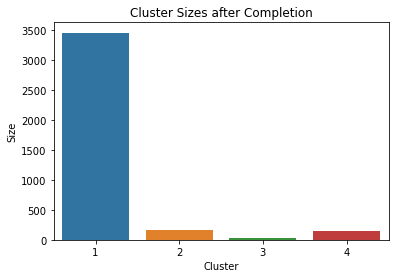

In [5]:
result_df: pd.DataFrame = pd.DataFrame()
result_df['Cluster'] = info[0] + 1
result_df['Size'] = info[1]
sns.barplot('Cluster', 'Size', data=result_df)
plt.title("Cluster Sizes after Completion")
plt.savefig("images/apply/cluster_sizes_dtw.png")